In [1]:
import sys
sys.executable

'/home/konan94/miniconda3/envs/sptag/bin/python'

In [2]:
import SPTAG

import numpy as np
import pandas as pd
from PIL import Image
import csv
import os
from os import listdir
from os.path import isfile, join, splitext
import shutil
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
%matplotlib inline

In [3]:
# generate test np
d = 2                           # dimension
nb = 100                      # database size
nq = 1                     # nb of queries
np.random.seed(1234)             # make reproducible

arr = np.random.random((nb, d)).astype('float32')


In [4]:
arr.shape

(100, 2)

In [5]:
xq = arr[1:2]
k = 5

In [8]:
def testBuild(algo, distmethod, x, out):
    i = SPTAG.AnnIndex(algo, 'Float', x.shape[1])
    i.SetBuildParam("NumberOfThreads", '4')
    i.SetBuildParam("DistCalcMethod", distmethod)
    ret = i.Build(x.tobytes(), x.shape[0])
    i.Save(out)
    
def testBuildWithMetaData(algo, distmethod, x, s, out):
    i = SPTAG.AnnIndex(algo, 'Float', x.shape[1])
    i.SetBuildParam("NumberOfThreads", '4')
    i.SetBuildParam("DistCalcMethod", distmethod)
    if i.BuildWithMetaData(x.tobytes(), s, x.shape[0]):
        i.Save(out)

def testSearch(index, q, k):
    j = SPTAG.AnnIndex.Load(index)
    for t in range(q.shape[0]):
        result = j.Search(q[t].tobytes(), k)
        print (result[0]) # ids
        print (result[1]) # distances

def testSearchWithMetaData(index, q, k):
    j = SPTAG.AnnIndex.Load(index)
    j.SetSearchParam("MaxCheck", '1024')
    for t in range(q.shape[0]):
        result = j.SearchWithMetaData(q[t].tobytes(), k)
        print (result[0]) # ids
        print (result[1]) # distances
        print (result[2]) # metadata

def testAdd(index, x, out, algo, distmethod):
    if index != None:
        i = SPTAG.AnnIndex.Load(index)
    else:
        i = SPTAG.AnnIndex(algo, 'Float', x.shape[1])
    i.SetBuildParam("NumberOfThreads", '4')
    i.SetBuildParam("DistCalcMethod", distmethod)
    if i.Add(x.tobytes(), x.shape[0]):
        i.Save(out)

def testAddWithMetaData(index, x, s, out, algo, distmethod):
    if index != None:
        i = SPTAG.AnnIndex.Load(index)
    else:
        i = SPTAG.AnnIndex(algo, 'Float', x.shape[1])
    i = SPTAG.AnnIndex(algo, 'Float', x.shape[1])
    i.SetBuildParam("NumberOfThreads", '4')
    i.SetBuildParam("DistCalcMethod", distmethod)
    if i.AddWithMetaData(x.tobytes(), s, x.shape[0]):
        i.Save(out)

def testDelete(index, x, out):
    i = SPTAG.AnnIndex.Load(index)
    ret = i.Delete(x.tobytes(), x.shape[0])
    print (ret)
    i.Save(out)

def Test(algo, distmethod):
    testBuild(algo, distmethod, arr, 'testindices')
    testSearch('testindices', xq, k)

In [9]:
# run test
if __name__ == '__main__':
    Test('BKT', 'L2')
    #Test('KDT', 'L2')

[1, 13, 88, 93, 48]
[0.0, 0.0016536564799025655, 0.005463525652885437, 0.008533643558621407, 0.010976185090839863]


# Download data

In [100]:
! curl -O http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  23.0M      0  0:00:05  0:00:05 --:--:-- 23.1M


In [ ]:
! tar xvzf 101_ObjectCategories.tar.gz

# Load helpers script

In [106]:
%run features_extractor.py

Using TensorFlow backend.


# Load data

In [107]:
filenames = get_filenames("101_ObjectCategories//**//*.*")

Found 9144 files using pattern: 101_ObjectCategories//**//*.*


In [111]:
imgs_np = get_images(filenames, target_size=(200,200), color='RGB', bg_clr=0)

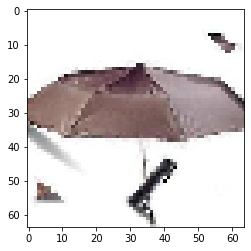

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgs_np[70])

In [113]:
imgs_np.shape

(9144, 64, 64, 3)

# Generate features

In [119]:
embeddings = extract_features(imgs_np, pretrained_model="vgg19")

Input images shape:  (9144, 64, 64, 3)
80142336/80134624 [==============================] - 2s 0us/step
Features shape:  (9144, 512)


In [118]:
embeddings[0]

array([0.        , 1.4380319 , 0.        , ..., 1.0015441 , 0.41706264,
       4.840535  ], dtype=float32)

# save embeddings to np file

In [132]:
# save np
np.save('caltech101_np_4096d.npy', embeddings)
np.save('caltech101_np_4096d_filenames.npy', filenames)

In [133]:
# load np
arr = np.load('caltech101_np_4096d.npy')
filenames = np.load('caltech101_np_4096d_filenames.npy')

# run indexing

In [124]:
xb = arr.astype('float32')

In [125]:
xb.shape

(9144, 512)

In [126]:
xq = xb[3:4]  # set query dataset

In [127]:
xq.shape

(1, 512)

# build sptag index

In [128]:
algo = 'KDT' # or BKT
distmethod = 'L2'
k = 5
%time testBuild(algo, distmethod, xb, 'sptag_indice')

CPU times: user 21min 14s, sys: 1.76 s, total: 21min 16s
Wall time: 11min 3s


In [129]:
def testSearch2(index, q, k):
    j = SPTAG.AnnIndex.Load(index)
    for t in range(q.shape[0]):
        result = []
        result.append(j.Search(q[t].tobytes(), k))
    return result

In [130]:
# query sptag index
%time search_result = testSearch2('sptag_indice', xq, k)

# searched 1 image
print(search_result[0][0]) # index
print(search_result[0][1]) # distance

CPU times: user 18.5 ms, sys: 3.99 ms, total: 22.5 ms
Wall time: 22.5 ms
[3, 3830, 6784, 6763, 6752]
[0.0, 28712.98046875, 28897.927734375, 31872.806640625, 33766.98046875]


In [141]:
filenames[0]

'101_ObjectCategories/umbrella/image_0037.jpg'

([3, 3830, 6784, 6763, 6752], [0.0, 28712.98046875, 28897.927734375, 31872.806640625, 33766.98046875], [<NULL>, <NULL>, <NULL>, <NULL>, <NULL>])
image index : 3
image distance : 0.0
image file : 101_ObjectCategories/umbrella/image_0030.jpg
image index : 3830
image distance : 28712.98046875
image file : 101_ObjectCategories/dragonfly/image_0036.jpg
image index : 6784
image distance : 28897.927734375
image file : 101_ObjectCategories/brain/image_0048.jpg
image index : 6763
image distance : 31872.806640625
image file : 101_ObjectCategories/brain/image_0007.jpg
image index : 6752
image distance : 33766.98046875
image file : 101_ObjectCategories/brain/image_0001.jpg


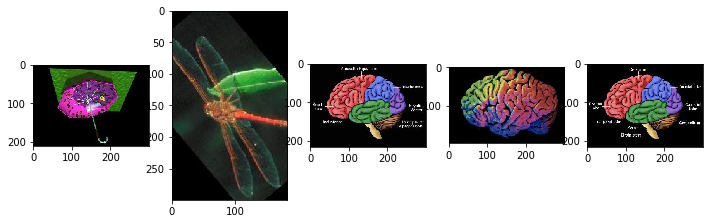

In [153]:
def draw_image5(img_indexes):
    print(img_indexes)
    w=10
    h=10
    fig=plt.figure(figsize=(12, 12))
    columns = 5
    rows = 1
    for i in range(1, columns*rows +1):
        print('image index : ' + str(img_indexes[0][i-1]))
        print('image distance : ' + str(img_indexes[1][i-1]))
        
        print('image file : ' + filenames[img_indexes[0][i-1]])
        p_img = Image.open(filenames[img_indexes[0]][i-1])
        img =  np.array(p_img) 
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    
draw_image5(search_result[0])